# Avocados Example
- The goal of this analysis is to produce granular forecasts with the avocado dataset by region and avocado type
- Using many models on each series could produce more accurate final forecasts
- Dataset available here: https://www.kaggle.com/neuromusic/avocado-prices

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm as log_progress
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.notebook import results_vis, tune_test_forecast
from scalecast.multiseries import export_model_summaries

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
# read data
data = pd.read_csv('avocado.csv',parse_dates=['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['region','type','Date'])

In [3]:
# download template validation grids (will not overwrite existing Grids.py file by default)
GridGenerator.get_example_grids(overwrite=False)

## Load Dictionary with Forecaster Objects
- Slice dataset by region and avocado type
- Fill any missing weeks with 0 (assume 0 sales)
- Set test length (26 weeks)

In [4]:
avc = {}
for reg in data.region.unique():
    for typ in data.type.unique():
        data_slice = data.loc[(data['region'] == reg) & (data['type'] == typ)]
        load_dates = pd.date_range(start=data_slice['Date'].min(),end=data_slice['Date'].max(),freq='W') # for missing weeks, assume 0
        data_load = pd.DataFrame({'Date':load_dates})
        data_load['Vol'] = data_load.merge(data_slice,how='left',on='Date')['Total Volume'].values
        data_load.fillna(0,inplace=True)
        f = Forecaster(y=data_load['Vol'],current_dates=data_load['Date'],type=typ,region=reg)
        f.set_test_length(26) # new in version 0.2.6 - set test length before running acf/pacf plots
        avc[f"{reg}-{typ}"] = f

In [5]:
# summaries
print(f'number of series to forecast: {len(avc)}')
print(f'number of actual weeks to forecast with: {len(load_dates)}')

number of series to forecast: 108
number of actual weeks to forecast with: 169


## EDA on Last Series Only
- Since there are 108 series, doing an exploratory analysis on all of them could be time-consuming
- We examine the last series only and hope that decisions made based on its statistical properties are generalizable to the other series
- An in-depth knowledge of the underlying data could also reasonably inform the decisions made in regards to lagging variables, adding seasonality, etc.
- We will examine ACF, PAC, and seasonal plots
- Exclude test set from all plots to not leak

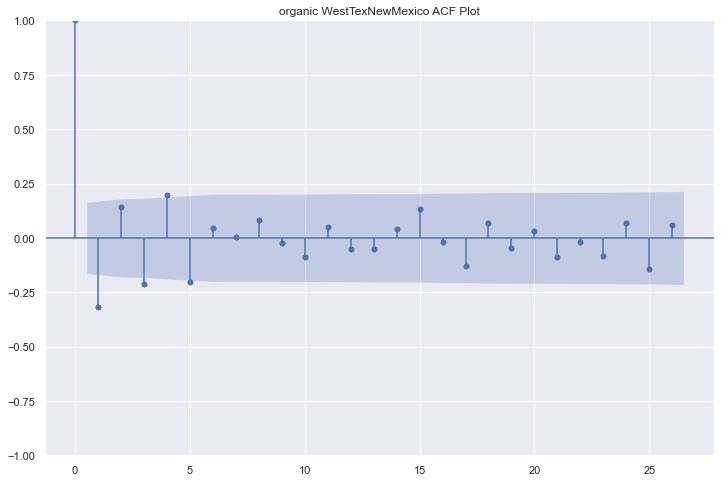

In [6]:
f.plot_acf(diffy=True,lags=26,train_only=True)
plt.title(f'{f.type} {f.region} ACF Plot')
plt.show()

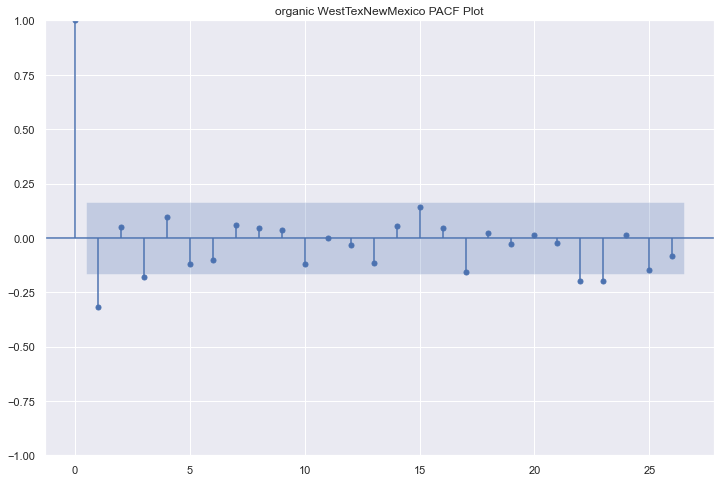

In [7]:
f.plot_pacf(diffy=True,lags=26,train_only=True)
plt.title(f'{f.type} {f.region} PACF Plot')
plt.show()

organic WestTexNewMexico Seasonal Decomposition


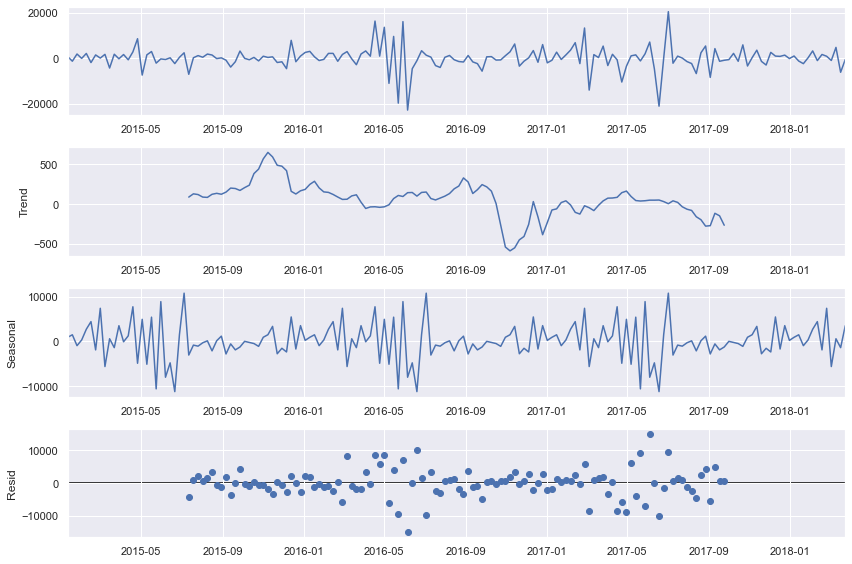

In [8]:
print(f'{f.type} {f.region} Seasonal Decomposition')
f.seasonal_decompose(diffy=True).plot()
plt.show()

## Loop through Dictionary and Forecast with 11 models
- Add 52 future dates (1 year)
- Set validation length of 5
  - we can usually afford to make the validation length shorter
  - there is a balancing act between having enough data to tune with and enough out-of-sample data to feel comfortable with the results from tuning
- Add five subsequent periods of lagged terms to forecast with
  - all forecasts fill in future lagged terms with predictions as necessary -- this slows down model evaluation but makes it dynamic and saves from overfitting
- Add two lagged terms 13 and 26 periods back respectively, a quarter and half year
- Difference each series up to 1 time according to results from an Augmented Dickey Fuller test
- Add week regressor with a wave transformation -- only adds two regressors to attempt to capture weekly cycles
- Add month and quarter regressors with dummy variables
- Add year and time trends
- Tune, test, and forecast all models

In [9]:
models = ('mlr','knn','svr','xgboost','gbt','elasticnet','mlp')

rerun = True # set to True if you want to rerun all forecasts, False will attempt to read in the pickle (avocado_results.pckl)
if rerun:
    for k, f in log_progress(avc.items()):
        print(f'now forecasting series {k}')
        f.generate_future_dates(52)
        f.set_validation_length(5)
        f.add_ar_terms(5)
        f.add_AR_terms((2,13))
        f.integrate(max_integration=1)
        f.add_seasonal_regressors('week',raw=False,sincos=True)
        f.add_seasonal_regressors('month','quarter',raw=False,dummy=True)
        f.add_seasonal_regressors('year')
        f.add_time_trend()
        tune_test_forecast(f,models)
        f.set_estimator('prophet')
        f.manual_forecast()
        f.set_estimator('silverkite')
        f.manual_forecast()
        f.set_estimator('combo')
        f.manual_forecast(how='weighted',models='top_7',call_me='weighted',rebalance_weights=0) # weighted average of top 7 models (based on validation performance)
        f.manual_forecast(how='simple',models='top_5',call_me='avg') # a simple average of top 5 models
        with open('avocado_results.pckl','wb') as f:
            pickle.dump(avc,f)
else:
    avc = pickle.load(open('avocado_results.pckl','rb'))

## Export Results to CSV
- Breaks down general performance, hyperparemeter selections, metrics, regressor info, etc.
- saved as avocado_model_summaries.csv

In [10]:
forecast_info = export_model_summaries(avc)
forecast_info.to_csv('avocado_model_summaries.csv',index=False)

## Model Analytics
- Overall median level MAPE of all models
- MAPEs broken down by models
- Which models were the best most often according to MAPE?

In [11]:
# reset some parameters to make plotting work
matplotlib.use('nbAgg')
%matplotlib inline
sns.set(rc={'figure.figsize':(12,6)})

In [12]:
def addlabels(df,r=2):
    """ adds labels to bar charts
        df : a pandas dataframe with the metric aggregated by model name
        r : the number of decimals to round labels to
    """
    for i in range(df.shape[0]):
        plt.text(i, df.iloc[i], df.iloc[i].round(r), ha = 'center')

In [13]:
print('median all models level MAPE: {}'.format(forecast_info['LevelTestSetMAPE'].median()))
print('median best models level MAPE: {}'.format(forecast_info.loc[forecast_info['best_model'], 'LevelTestSetMAPE'].median()))

median all models level MAPE: 0.21349303075050827
median best models level MAPE: 0.18005973014793433


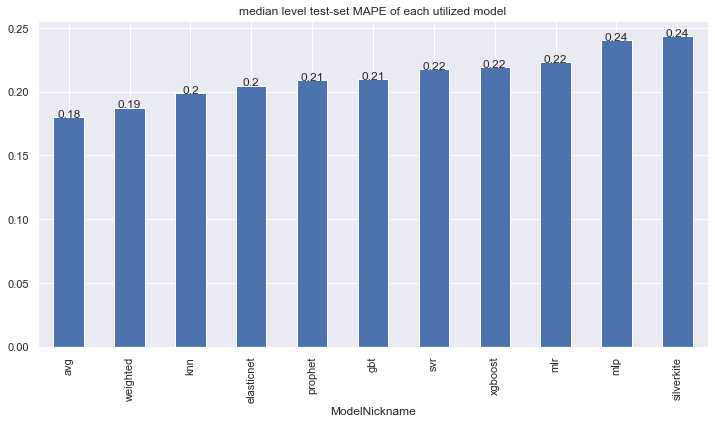

In [16]:
df2 = forecast_info.groupby('ModelNickname')['LevelTestSetMAPE'].median().sort_values()
df2.plot.bar()
addlabels(df2)
plt.title('median level test-set MAPE of each utilized model')
plt.show()

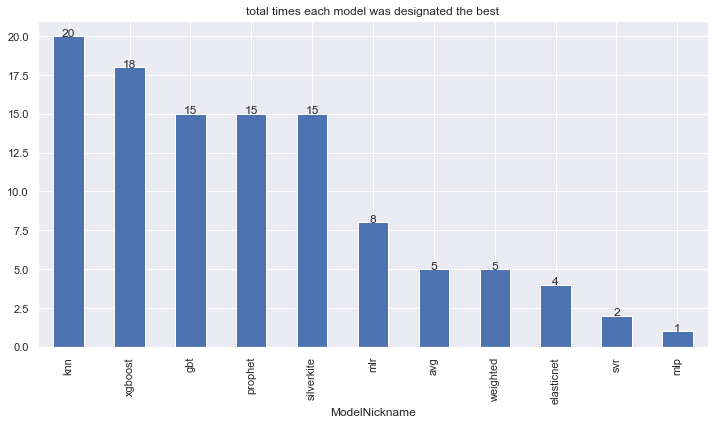

In [17]:
df3 = forecast_info.groupby('ModelNickname')['best_model'].sum().sort_values(ascending=False)
df3.plot.bar()
addlabels(df3,0)
plt.title('total times each model was designated the best')
plt.show()

## Visualize Results
- the next two functions leverage Jupyter widgets and will only display if running the notebook locally
- allows the user to toggle through both forecast and test-set results for each time series

In [18]:
results_vis(avc,'forecast',print_attr=['LevelTestSetMAPE','Scaler','HyperParams','Xvars','models','Integration'])

Dropdown(description='Time Series:', options=('Albany-conventional', 'Albany-organic', 'Atlanta-conventional',…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelT…

Button(description='Select Time Series', style=ButtonStyle())

Output()

In [19]:
results_vis(avc,'test',include_train=52)

Dropdown(description='Time Series:', options=('Albany-conventional', 'Albany-organic', 'Atlanta-conventional',…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelT…

Button(description='Select Time Series', style=ButtonStyle())

Output()

## Pickle Results
- saves results to a pickle file to be loaded in later (instead of rerunning the whole notebook)

In [20]:
with open('avocado_results.pckl','wb') as f:
    pickle.dump(avc,f)